


# 基于滑模控制的路面识别和汽车ABS控制

**主要内容**

- 路面识别：最佳滑移率估计

- 滑模控制逻辑

- 测试实验


## 路面识别：基于$\mu-\lambda$曲线的最佳滑移率估计

### 控制思想

对于滑模控制而言，最重要的是要对于路面条件进行观测得到最佳的滑移率从而进行有效的控制。

而$\mu-\lambda$曲线是强非线性的函数，想要利用参数模型进行准确表示是很困难的，而从曲线的形状

来进行最佳滑移率$\lambda_d$的寻找却是可行的。观察其特点可以发现：

1. 在曲线的稳定区域即$\lambda < \lambda_d$的区域随着滑移率的变大附着系数逐渐增大，此时曲线的斜率为正

2. 在曲线的非稳定区域即$\lambda > \lambda_d$的区域随着滑移率的增大附着系数逐渐减小，此时曲线的斜率为负

3. 在$\lambda = \lambda_d$处，附着系数达到极值，此时曲线斜率为零

显然，并不需要非常精确的估计出$\lambda_d$的值才能实现所需要的控制，而只需要判断关系曲线的形状

就可以确定是否应该增大或者减小制动力矩的输出。


### 实际推导

制动时，车轮受到制动力矩$T_b$的作用，车轮既有滚动又有一定程度的与地面之间的滑动，而由车轮附着系数

和滑移率之间的曲线关系可以知道，即使很小的滑动也将导致附着系数的急剧增加，所以相对于地面附着力$F_t$而

言滚动阻力在整个制动过程中的影响比较小，所以在制动过程这样对于精度要求不是很高的问题中，可以进行忽略。

**单轮模型**

基于单轮模型，车轮制动时的方程可以简化为：

$$
J \dot{w} = F_t \cdot R - T_b
$$

进一步的有

$$
J \dot{w} = \mu(\lambda)F_z \cdot R - T_b
$$

可以得到

$$
\mu(\lambda) = \frac{J\dot{w}+T_b}{F_z \cdot R}
$$

上式对时间求导得到

$$
\frac{d\mu}{dt} = \frac{J\ddot{w}+\dot{T_b}}{F_z \cdot R
}
$$

而车轮滑移率的定义公式：

$$
\lambda = \frac{V - w \cdot R}{V} = 1 - \frac{w \cdot R}{V}
$$

求导得到滑移率随着时间的变化

$$
\frac{d\lambda}{dt} = \frac{wR\dot{V}-VR\dot{w}}{V^2}
$$

综合可以得到

$$
\frac{d\mu}{d\lambda} = \frac{d\mu / dt}{d\lambda/dt} = \frac{J \ddot{w} + \dot{T_b}}{F_z \cdot R} \cdot \frac{V^2}{wR\dot{V} - VR\dot{w}}
$$

而上式中 $V,R,F_z$均为正数，所以$\frac{d\mu}{d\lambda}$的正负即取决于 $\frac{J\ddot{w} + \dot{T_b}}{wR\dot{V} - VR\dot{w}}$的正负决定的。




### 路面观测 —— 最佳滑移率



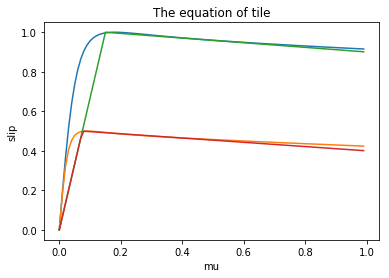

In [4]:
import numpy as np
import math
import matplotlib.pylab as plt

# set parameters
m = 450
g = 9.8
r = 0.32
I = 1
v0 = 25
w0 = v0/r
flag = 1

Mb_base = 4000 #2000 #5000
step = 1000 #500 #1000
dM = Mb_base/step # 0.02s

# gravity force
FN = m*g

time = 10
# step size
h = 0.0001
size = int(time/h)

v = np.zeros(size)
w = np.zeros(size)
T = np.linspace(0,time,size)
w_a = np.zeros(size)
w_aa = np.zeros(size) # aa is the dereviate of a
slipratio = np.zeros(size)
slipError = np.zeros(size)
slip_a = np.zeros(size)
slip_aa = np.zeros(size)
Mb = np.zeros(size)
a = np.zeros(size)

sym = np.zeros(size)

v[0] = v0
w[0] = w0
a[0] = 0
epsilon = 0.2 

x = np.arange(0,1,0.01)
y = np.zeros(100)
yy = np.zeros(100)
z = np.zeros(100)
zz = np.zeros(100)
for i in range(100):
    y[i] = math.sin(1.9*math.atan(10*x[i]-0.97*(10*x[i]-math.atan(10*x[i]))))
    yy[i] = 0.5*math.sin(1.9*math.atan(10*2*x[i]-0.97*(10*2*x[i]-math.atan(10*2*x[i]))))
    if x[i] <= 0.15:
        z[i] = x[i]/0.15

    elif x[i] > 0.15:
        z[i] = 1.0 - 0.1*(x[i]-0.15)/(1-0.15)
     
    if x[i] <= 0.075:
        zz[i] = 0.5*x[i]/0.075
    elif x[i] > 0.075:
        zz[i] = 0.5 - 0.1*(x[i]-0.075)/(1-0.075)

plt.figure()
plt.plot(x,y)
plt.plot(x,yy)
plt.plot(x,z)
plt.plot(x,zz)
plt.title("The equation of tile")
plt.xlabel("mu")
plt.ylabel("slip")
plt.show()

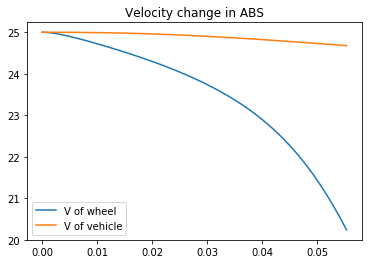

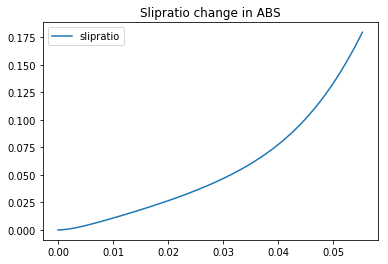

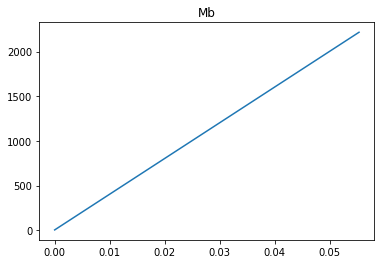

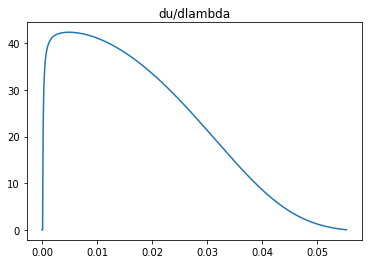

lambda 0.1807306067900564


In [7]:
for i in range(size-1):
    slipratio[i] = (v[i]-w[i]*r)/max(v[i],w[i]*r) #calculate the slip ratio
    
    if slipratio[i] > 1:
        #print(slipratio[i],">1")
        slipratio[i] = 1
    elif slipratio[i] < 0:
        slipratio[i] = slipratio[i]  # adjust the limits if exceeds
  
    if i > 0:
        w_a[i] = (w[i] - w[i-1])/h
        a[i] = (v[i] - v[i-1])/h
        w_aa[i] = (w_a[i] - w_a[i-1])/h
        slip_a[i] = (slipratio[i] - slipratio[i-1])/h
        slip_aa[i] = (slip_a[i] - slip_a[i-1])/h
    
    #u = 1.28*(1-math.exp(-23.99*slipratio[i]) - 0.52*slipratio[i]);  
    
    if i<step:
        
        Mb[i] = Mb[i-1] + dM
    else:
        
        Mb[i] = Mb[i-1]
                
  
    
    if flag == 0:    
        u = math.sin(1.9*math.atan(10*slipratio[i]-0.97*(10*slipratio[i]-math.atan(10*slipratio[i]))))
    else:
        u = 0.5*math.sin(1.9*math.atan(10*2*slipratio[i]-0.97*(10*2*slipratio[i]-math.atan(10*2*slipratio[i]))))
    #u = 1.28*(1-math.exp(-23.99*slipratio[i]) - 0.52*slipratio[i]);
    
    if i > 0:
        sym[i] = (I*w_aa[i]+((Mb[i]-Mb[i-1])/h))/(w[i]*r*a[i]-v[i]*r*w_a[i])
    if sym[i] < 0:
        sign_i = i-1
        t_pos = sign_i
        break
    
    dw = (r*u*FN - Mb[i])/I*h
    w[i+1] = w[i]+dw
    
    dv = -u*FN/m*h
    v[i+1] = v[i] + dv
    
    if w[i]*r < 0:
        t_pos = i+1
        break
    
    if v[i+1] < 0.2:
        v[i+1] = 0
        t_pos = i+1
        break

v_w = w*r
    
plt.figure()

#plt.plot(T,v)
plt.plot(T[0:t_pos],v_w[0:t_pos],label = "V of wheel")
plt.plot(T[0:t_pos],v[0:t_pos],label = "V of vehicle")
plt.legend(loc = 'best')
plt.title('Velocity change in ABS')
#plt.savefig('velocity',dpi = 200)

plt.figure()
plt.plot(T[0:t_pos],slipratio[0:t_pos], label = "slipratio")
plt.legend(loc = 'best')
plt.title("Slipratio change in ABS")
#plt.savefig("slipratio",dpi = 200)

plt.figure()
plt.plot(T[0:t_pos],Mb[0:t_pos], label = "Mb")
plt.title("Mb")
plt.show()

plt.figure()
plt.plot(T[0:t_pos],sym[0:t_pos], label = "du/dlambda")
plt.title("du/dlambda")
plt.show()

print('lambda',slipratio[sign_i])

可以看出在上面，成功的识别出了最佳的滑移率


## 滑模控制

采取一种光滑滑模的控制算法，可以有效抑制传统滑模算法的震荡特性。

对于 ABS 系统，选取滑移率为控制对象，通过期望的滑移率 $\lambda_d$，以消除

追踪误差为目标，控制车轮的滑移率保持在期望的滑移率附近，对于单轮模型其车辆动力学模型为

$$
M\dot{v} = -F_s
$$

$$
J\dot{w} = F_sR - T_b
$$

$$
F_s = \mu 
F_z
$$

代入滑移率对时间导数得到

$$
\dot{\lambda} = - \frac{\mu g}{v}\left[ (1 - \lambda)+ \frac{MR^2}{J} \right] + \frac{T_bR}{Jv}= f(\lambda,t)+b(\lambda,t)\mu(t)
$$

选取制动力矩$T_b$为控制变量，控制目的是使得滑移率遵循期望的轨迹变化，对于滑移率定义滑移面

$$
s = \lambda - \lambda_d
$$

显然，当系统
沿着滑动超平面运动时，恒成立

$$
\dot{S(t)} = 0
$$

可以求解出等效的控制力矩 $T_{beq}$ 为

$$
T_{beq} = \frac{J\mu g}{R}(1-\lambda) + \mu MgR
$$

当系统在滑动超平面之外时，需要加入罚项，保证系统状态可以达到滑动超平面

$$
T_{p} = \beta sgn(s)
$$

滑模控制需要满足可达条件

$$
s\dot{s} \leq -\eta |s|
$$

进一步得到

$$
\beta \ge \eta \frac{Jv}{R}
$$

从而可以得到系统控制量

$$
T_b = T_{beq} + T_p = \frac{J\mu g}{R}(1-\lambda) + \mu MgR + \beta sgn(s)
$$

然而对于这一的系统其罚项的切换的不连续性会导致抖颤，所以采用换为光滑的控制，用系统状态到滑动面的距离

即滑动函数代替符号函数，得到

$$
T_b =\frac{J\mu g}{R}(1-\lambda) + \mu MgR + \rho s
$$



Final time 20114 2.011420114201142


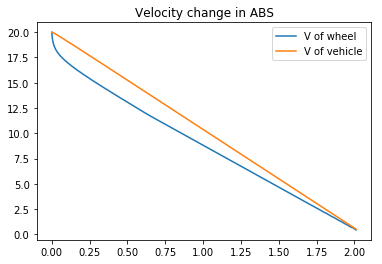

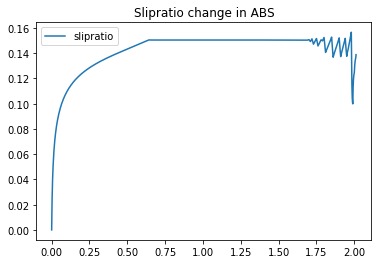

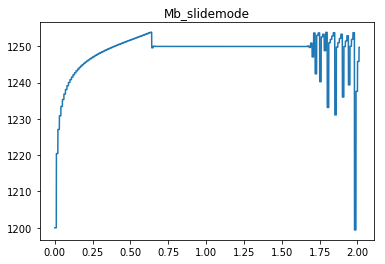

In [15]:
# -*- coding: utf-8 -*-
"""
Created on Wed Jan 16 09:36:59 2019

@author: feiyuxiao
"""

import numpy as np
import math
import matplotlib.pylab as plt

# set parameters
m = 380
g = 9.8
r = 0.325
I = 1.7
v0 = 20
w0 = v0/r

flag = 0
desireSlip = 0.15

slip = 0.15
mu = 1.0


K = 8000 #7700 #8000

# gravity force
FN = m*g

time = 10
# step size
h = 0.0001
size = int(time/h)

v = np.zeros(size)
w = np.zeros(size)
T = np.linspace(0,time,size)
slipratio = np.zeros(size)
slipError = np.zeros(size)
Mb = np.zeros(size)


epsilon = 0.2

v[0] = v0
w[0] = w0


for i in range(size-1):
   
    if i < 25000:
        flag = 0
        desiredSlip = 0.15
        slip = 0.15
        mu = 1.0
    elif i >= 25000:
        flag = 1
        desiredSlip = 0.075
        slip = 0.075
        mu = 0.5
  
    slipratio[i] = (v[i]-w[i]*r)/max(v[i],w[i]*r,epsilon) #calculate the slip ratio
    
    
    #print(slipratio[i],i)   
    slipError[i] = slipratio[i] - desiredSlip# e
      
    if flag == 0:
        if slipratio[i] < slip:
            u_lambda = slipratio[i]/slip
        elif slipratio[i] >= slip:
            u_lambda = 1.0 - 0.1*(slipratio[i]-slip)/(1-slip)
    elif flag == 1:
         if slipratio[i] < slip:
            u_lambda = mu*slipratio[i]/slip
         elif slipratio[i] >= slip:
            u_lambda = mu - 0.1*(slipratio[i]-slip)/(1-slip)
            
    
    #u = 1.28*(1-math.exp(-23.99*slipratio[i]) - 0.52*slipratio[i]);        
            
    if i%100 == 0:
        '''
        K = 400
        theta = 0.5
        Mb[i] = I*u_lambda*g*(1-slipratio[i])/r + u_lambda*m*g*r - K*sat(slipError[i],theta)
        '''
        Mb[i] = I*u_lambda*g*(1-slipratio[i])/r + u_lambda*m*g*r - K*slipError[i]
        '''
        if abs(slipError[i]<0.001) :
           print("slip",Mb[i],K*slipError[i])
        if v[i] < 0.5:
            Mb[i] = I*u_lambda*g*(1-slipratio[i])/r + u_lambda*m*g*r
        '''
        #print("u",u_lambda,slipratio[i])
    else:
        Mb[i] = Mb[i-1]
    
    if flag == 0:    
        u = math.sin(1.9*math.atan(10*slipratio[i]-0.97*(10*slipratio[i]-math.atan(10*slipratio[i]))))
    else:
        u = 0.5*math.sin(1.9*math.atan(10*2*slipratio[i]-0.97*(10*2*slipratio[i]-math.atan(10*2*slipratio[i]))))
    #u = 1.28*(1-math.exp(-23.99*slipratio[i]) - 0.52*slipratio[i]);
    
    dw = (r*u*FN - Mb[i])/I*h
    w[i+1] = w[i]+dw
    
    dv = -u*FN/m*h
    v[i+1] = v[i] + dv
    
    if v[i+1] < 0.5:
        v[i+1] = 0
        t_pos = i+1
        break

v_w = w*r
print("Final time",t_pos,T[t_pos])
   
plt.figure()
plt.plot(T[0:t_pos],v_w[0:t_pos],label = "V of wheel")
plt.plot(T[0:t_pos],v[0:t_pos],label = "V of vehicle")
plt.legend(loc = 'best')
plt.title('Velocity change in ABS')
plt.show()
#plt.savefig('velocity_slidemode.png',dpi = 200)

plt.figure()
plt.plot(T[0:t_pos],slipratio[0:t_pos], label = "slipratio")
plt.legend(loc = 'best')
plt.title("Slipratio change in ABS")
plt.show()
#plt.savefig("slipratio_slidemode.png",dpi = 200)

plt.figure()
plt.plot(T[0:t_pos],Mb[0:t_pos], label = "Mb")
plt.title("Mb_slidemode")
plt.show()
#plt.savefig("Mb_slidemode.png",dpi = 200)


Final time 40084 4.008440084400844


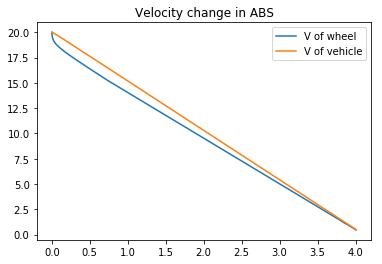

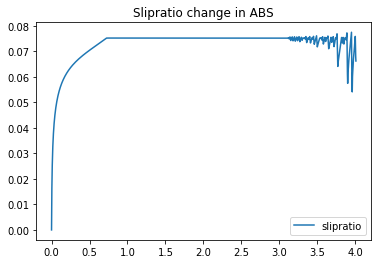

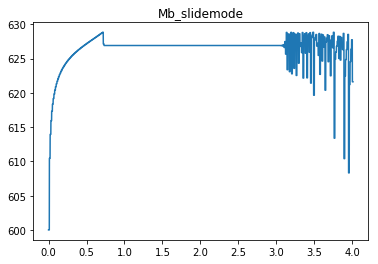

In [18]:

for i in range(size-1):
   
    if i > 45000:
        flag = 0
        desiredSlip = 0.15
        slip = 0.15
        mu = 1.0
    elif i <= 45000:
        flag = 1
        desiredSlip = 0.075
        slip = 0.075
        mu = 0.5
  
    slipratio[i] = (v[i]-w[i]*r)/max(v[i],w[i]*r,epsilon) #calculate the slip ratio
    
    
    #print(slipratio[i],i)   
    slipError[i] = slipratio[i] - desiredSlip# e
      
    if flag == 0:
        if slipratio[i] < slip:
            u_lambda = slipratio[i]/slip
        elif slipratio[i] >= slip:
            u_lambda = 1.0 - 0.1*(slipratio[i]-slip)/(1-slip)
    elif flag == 1:
         if slipratio[i] < slip:
            u_lambda = mu*slipratio[i]/slip
         elif slipratio[i] >= slip:
            u_lambda = mu - 0.1*(slipratio[i]-slip)/(1-slip)
            
    
    #u = 1.28*(1-math.exp(-23.99*slipratio[i]) - 0.52*slipratio[i]);        
            
    if i%100 == 0:
        '''
        K = 400
        theta = 0.5
        Mb[i] = I*u_lambda*g*(1-slipratio[i])/r + u_lambda*m*g*r - K*sat(slipError[i],theta)
        '''
        Mb[i] = I*u_lambda*g*(1-slipratio[i])/r + u_lambda*m*g*r - K*slipError[i]
        '''
        if abs(slipError[i]<0.001) :
           print("slip",Mb[i],K*slipError[i])
        if v[i] < 0.5:
            Mb[i] = I*u_lambda*g*(1-slipratio[i])/r + u_lambda*m*g*r
        '''
        #print("u",u_lambda,slipratio[i])
    else:
        Mb[i] = Mb[i-1]
    
    if flag == 0:    
        u = math.sin(1.9*math.atan(10*slipratio[i]-0.97*(10*slipratio[i]-math.atan(10*slipratio[i]))))
    else:
        u = 0.5*math.sin(1.9*math.atan(10*2*slipratio[i]-0.97*(10*2*slipratio[i]-math.atan(10*2*slipratio[i]))))
    #u = 1.28*(1-math.exp(-23.99*slipratio[i]) - 0.52*slipratio[i]);
    
    dw = (r*u*FN - Mb[i])/I*h
    w[i+1] = w[i]+dw
    
    dv = -u*FN/m*h
    v[i+1] = v[i] + dv
    
    if v[i+1] < 0.5:
        v[i+1] = 0
        t_pos = i+1
        break

v_w = w*r
print("Final time",t_pos,T[t_pos])
   
plt.figure()
plt.plot(T[0:t_pos],v_w[0:t_pos],label = "V of wheel")
plt.plot(T[0:t_pos],v[0:t_pos],label = "V of vehicle")
plt.legend(loc = 'best')
plt.title('Velocity change in ABS')
plt.show()
#plt.savefig('velocity_slidemode.png',dpi = 200)

plt.figure()
plt.plot(T[0:t_pos],slipratio[0:t_pos], label = "slipratio")
plt.legend(loc = 'best')
plt.title("Slipratio change in ABS")
plt.show()
#plt.savefig("slipratio_slidemode.png",dpi = 200)

plt.figure()
plt.plot(T[0:t_pos],Mb[0:t_pos], label = "Mb")
plt.title("Mb_slidemode")
plt.show()
#plt.savefig("Mb_slidemode.png",dpi = 200)


### 添加了路面识别——以对接路面为例

The desired sliprate 0.1811096519597769
Estimated ground condition 1


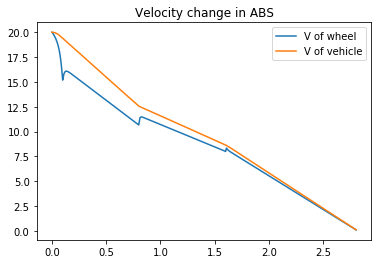

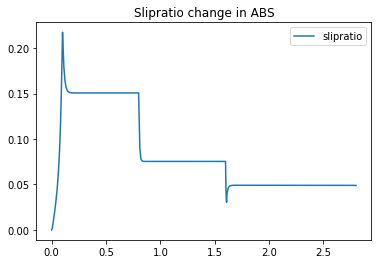

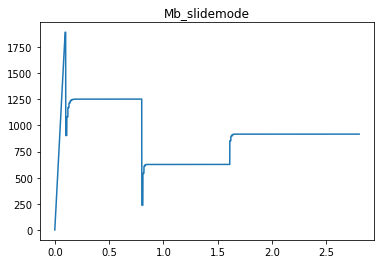

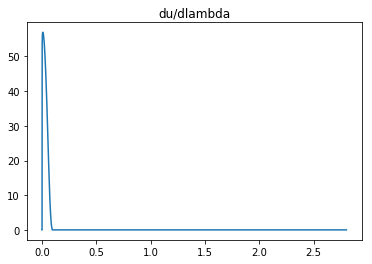

In [21]:
# -*- coding: utf-8 -*-
"""
Created on Wed Jan 16 09:36:59 2019

@author: feiyuxiao
"""

import numpy as np
import math
import matplotlib.pylab as plt

# set parameters
m = 380
g = 9.8
r = 0.325
I = 1.7
v0 = 20
w0 = v0/r

# estimate
flag = 1
Mb_base = 2000 
step = 1000 
# flag = 0 高附 Mb_base = 1000 step = 100 t_estimate = 0.1
# flag = 1 低附 Mb_base = 1000 step = 100
dM = Mb_base/step # 0.02s

K = 5000 #7700 #8000

# gravity force
FN = m*g

time = 10
# step size
h = 0.0001
size = int(time/h)

v = np.zeros(size)
w = np.zeros(size)
T = np.linspace(0,time,size)
slipratio = np.zeros(size)
slipError = np.zeros(size)
Mb = np.zeros(size)

w_a = np.zeros(size)
w_aa = np.zeros(size) # aa is the dereviate of a

slip_a = np.zeros(size)
slip_aa = np.zeros(size)
Mb = np.zeros(size)
a = np.zeros(size)

sym = np.zeros(size)
epsilon = 0.2

v[0] = v0
w[0] = w0

estimate = 1

for i in range(size-1):
    
    if i < 8000:
        flag = 0
        desiredSlip = 0.15
        slip = 0.15
        mu = 1.0
    elif i >= 8000 and i <=16000:
        flag = 1
        desiredSlip = 0.075
        slip = 0.075
        mu = 0.5
    elif i >= 16000:
        flag = 0
        desiredSlip = 0.15
        slip = 0.15
        mu = 1.0
    
   
    slipratio[i] = (v[i]-w[i]*r)/max(v[i],w[i]*r,epsilon) #calculate the slip ratio
    #u = 1.28*(1-math.exp(-23.99*slipratio[i]) - 0.52*slipratio[i]);    
        
    if estimate == 1: # estimate the ground
        if i > 0:
            w_a[i] = (w[i] - w[i-1])/h
            a[i] = (v[i] - v[i-1])/h
            w_aa[i] = (w_a[i] - w_a[i-1])/h
            slip_a[i] = (slipratio[i] - slipratio[i-1])/h
            slip_aa[i] = (slip_a[i] - slip_a[i-1])/h
        if i<step:
            Mb[i] = Mb[i-1] + dM
        if i > 0:
            sym[i] = (I*w_aa[i]+((Mb[i]-Mb[i-1])/h))/(w[i]*r*a[i]-v[i]*r*w_a[i])
        if sym[i] < 0:
            sign_i = i-1
            estimate = 0
            desiredSlip = slipratio[sign_i]
            slip = desiredSlip
            if desiredSlip < 0.1:
                mu = 0.5
            else:
                mu = 1
            print("The desired sliprate",slip) 
            print("Estimated ground condition",mu)
    else:
         
    
    
        #print(slipratio[i],i)   
        slipError[i] = slipratio[i] - desiredSlip# e
          
        if flag == 0:
            if slipratio[i] < slip:
                u_lambda = slipratio[i]/slip
            elif slipratio[i] >= slip:
                u_lambda = 1.0 - 0.1*(slipratio[i]-slip)/(1-slip)
        elif flag == 1:
             if slipratio[i] < slip:
                u_lambda = mu*slipratio[i]/slip
             elif slipratio[i] >= slip:
                u_lambda = mu - 0.1*(slipratio[i]-slip)/(1-slip)
            
           
        if i%100 == 0:
            '''
            K = 400
            theta = 0.5
            Mb[i] = I*u_lambda*g*(1-slipratio[i])/r + u_lambda*m*g*r - K*sat(slipError[i],theta)
            '''
            Mb[i] = I*u_lambda*g*(1-slipratio[i])/r + u_lambda*m*g*r - K*slipError[i]
            '''
            if abs(slipError[i]<0.001) :
               print("slip",Mb[i],K*slipError[i])
            if v[i] < 0.5:
                Mb[i] = I*u_lambda*g*(1-slipratio[i])/r + u_lambda*m*g*r
            '''
            #print("u",u_lambda,slipratio[i])
        else:
            Mb[i] = Mb[i-1]
    
    if flag == 0:    
        u = math.sin(1.9*math.atan(10*slipratio[i]-0.97*(10*slipratio[i]-math.atan(10*slipratio[i]))))
    else:
        u = 0.5*math.sin(1.9*math.atan(10*2*slipratio[i]-0.97*(10*2*slipratio[i]-math.atan(10*2*slipratio[i]))))
    #u = 1.28*(1-math.exp(-23.99*slipratio[i]) - 0.52*slipratio[i]);
    
    dw = (r*u*FN - Mb[i])/I*h
    w[i+1] = w[i]+dw
    
    dv = -u*FN/m*h
    v[i+1] = v[i] + dv
    
    if v[i+1] < 0.1:
        v[i+1] = 0
        t_pos = i+1
        break

v_w = w*r
   
plt.figure()
plt.plot(T[0:t_pos],v_w[0:t_pos],label = "V of wheel")
plt.plot(T[0:t_pos],v[0:t_pos],label = "V of vehicle")
plt.legend(loc = 'best')
plt.title('Velocity change in ABS')
#plt.savefig('velocity_slidemode.png',dpi = 200)

plt.figure()
plt.plot(T[0:t_pos],slipratio[0:t_pos], label = "slipratio")
plt.legend(loc = 'best')
plt.title("Slipratio change in ABS")
#plt.savefig("slipratio_slidemode.png",dpi = 200)

plt.figure()
plt.plot(T[0:t_pos],Mb[0:t_pos], label = "Mb")
plt.title("Mb_slidemode")
#plt.savefig("Mb_slidemode.png",dpi = 200)

plt.figure()
plt.plot(T[0:t_pos],sym[0:t_pos], label = "du/dlambda")
plt.title("du/dlambda")
plt.show()


### 在一定噪音下的控制

路面的摩擦加入-0%-2%的随机扰动

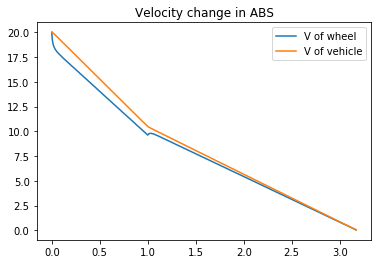

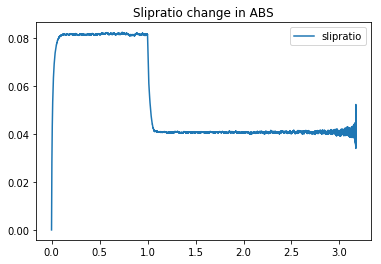

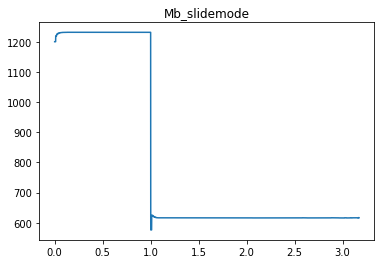

In [2]:
# -*- coding: utf-8 -*-
"""
Created on Wed Jan 16 09:36:59 2019

@author: feiyuxiao
"""

import numpy as np
import math
import matplotlib.pylab as plt
import random

# set parameters
m = 380
g = 9.8
r = 0.325

I = 1.7
v0 = 20
w0 = v0/r
#desiredSlip = 0.075
#flag = 1 # flag 1 low mu  flag 0 high mu

K = 8000

# gravity force
FN = m*g

time = 8
# step size
h = 0.0001
size = int(time/h)

v = np.zeros(size)
w = np.zeros(size)
T = np.linspace(0,time,size)
a = np.zeros(size)
aa = np.zeros(size) # aa is the dereviate of a
slipratio = np.zeros(size)
slipError = np.zeros(size)

Mb = np.zeros(size)

v[0] = v0
w[0] = w0


i = 0

for i in range(size-1):
  
    if i < 10000:
        flag = 0
        desiredSlip = 0.15
    elif i >= 10000:
        flag = 1
        desiredSlip = 0.075
    
    slipratio[i] = (v[i]-w[i]*r)/v[i] #calculate the slip ratio

    slipError[i] = slipratio[i] - desiredSlip# e
    
    if flag == 0:
        if slipratio[i] < 0.15:
            u_lambda = slipratio[i]/0.15
        elif slipratio[i] >= 0.15:
            u_lambda = 1.0 - 0.1*(slipratio[i]-0.15)/(1-0.15)
    elif flag == 1:
         if slipratio[i] < 0.075:
            u_lambda = 0.5 * slipratio[i]/0.075
         elif slipratio[i] >= 0.075:
            u_lambda = 0.5 - 0.1*(slipratio[i]-0.075)/(1-0.075)
            
          
    if i%100 == 0:
        '''
        K = 400
        theta = 0.5
        Mb[i] = I*u_lambda*g*(1-slipratio[i])/r + u_lambda*m*g*r - K*sat(slipError[i],theta)
        '''
        Mb[i] = I*u_lambda*g*(1-slipratio[i])/r + u_lambda*m*g*r - K*slipError[i]
    else:
        Mb[i] = Mb[i-1]
            
    
    if flag == 0:    
        u = math.sin(1.9*math.atan(10*slipratio[i]-0.97*(10*slipratio[i]-math.atan(10*slipratio[i])))) 
        u = (1 + 0.01*random.randint(5,10))*u
    elif flag == 1:
        u = 0.5*math.sin(1.9*math.atan(10*2*slipratio[i]-0.97*(10*2*slipratio[i]-math.atan(10*2*slipratio[i]))))
        u = (1 + 0.01*random.randint(5,10))*u
    #u = 1.28*(1-math.exp(-23.99*slipratio[i]) - 0.52*slipratio[i]);
    
    dw = (r*u*FN - Mb[i])/I*h
    w[i+1] = w[i]+dw
    
    dv = -u*FN/m*h
    v[i+1] = v[i] + dv
    
    if v[i+1] < 0.05:
        v[i+1] = 0
        t_pos = i+1
        break

v_w = w*r
    
plt.figure()
plt.plot(T[0:t_pos],v_w[0:t_pos],label = "V of wheel")
plt.plot(T[0:t_pos],v[0:t_pos],label = "V of vehicle")
plt.legend(loc = 'best')
plt.title('Velocity change in ABS')
plt.show()
#plt.savefig('velocity_slidemode.png',dpi = 200)

plt.figure()
plt.plot(T[0:t_pos],slipratio[0:t_pos], label = "slipratio")
plt.legend(loc = 'best')
plt.title("Slipratio change in ABS")
plt.show()
#plt.savefig("slipratio_slidemode.png",dpi = 200)

plt.figure()
plt.plot(T[0:t_pos],Mb[0:t_pos], label = "Mb")
plt.title("Mb_slidemode")
plt.show()
#plt.savefig("Mb_slidemode.png",dpi = 200)


### 对滑移率估计的稳定性——低估目标滑移率
以低附到高附的对接路面为例：
如果对高附的最优滑移率的估测有误差低估为0.10(准确是0.15)

Text(0.5,1,'Mb_slidemode')

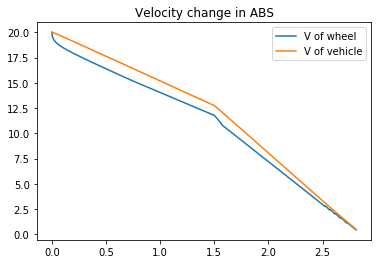

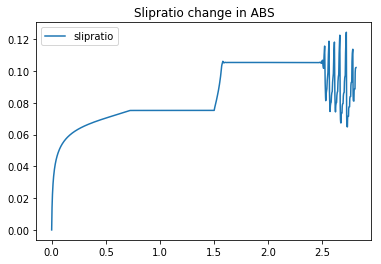

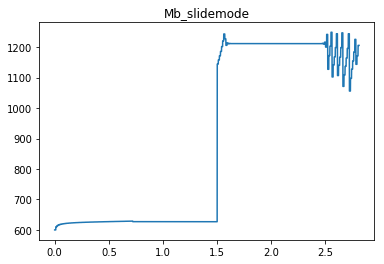

In [5]:
# -*- coding: utf-8 -*-
"""
Created on Wed Jan 16 09:36:59 2019

@author: feiyuxiao
"""

import numpy as np
import math
import matplotlib.pylab as plt

# set parameters
m = 380
g = 9.8
r = 0.325
I = 1.7
v0 = 20
w0 = v0/r

flag = 0
desireSlip = 0.075

slip = 0.075
mu = 1.0


K = 8000 #7700 #8000

# gravity force
FN = m*g

time = 10
# step size
h = 0.0001
size = int(time/h)

v = np.zeros(size)
w = np.zeros(size)
T = np.linspace(0,time,size)
slipratio = np.zeros(size)
slipError = np.zeros(size)
Mb = np.zeros(size)


epsilon = 0.2

v[0] = v0
w[0] = w0


for i in range(size-1):
   
    if i >= 15000:
        flag = 0
        desiredSlip = 0.10
        slip = 0.10
        mu = 1
    
    elif i< 15000:
        flag = 1
        desiredSlip = 0.075
        slip = 0.075
        mu = 0.基于路面识别的基于5 
  
    slipratio[i] = (v[i]-w[i]*r)/max(v[i],w[i]*r,epsilon) #calculate the slip ratio
    
    
    #print(slipratio[i],i)   
    slipError[i] = slipratio[i] - desiredSlip# e
      
    if flag == 0:
        if slipratio[i] < slip:
            u_lambda = slipratio[i]/slip
        elif slipratio[i] >= slip:
            u_lambda = 1.0 - 0.1*(slipratio[i]-slip)/(1-slip)
    elif flag == 1:
         if slipratio[i] < slip:
            u_lambda = mu*slipratio[i]/slip
         elif slipratio[i] >= slip:
            u_lambda = mu - 0.1*(slipratio[i]-slip)/(1-slip)
            
    
    #u = 1.28*(1-math.exp(-23.99*slipratio[i]) - 0.52*slipratio[i]);        
            
    if i%100 == 0:
        '''
        K = 400
        theta = 0.5
        Mb[i] = I*u_lambda*g*(1-slipratio[i])/r + u_lambda*m*g*r - K*sat(slipError[i],theta)
        '''
        Mb[i] = I*u_lambda*g*(1-slipratio[i])/r + u_lambda*m*g*r - K*slipError[i]
        '''
        if abs(slipError[i]<0.001) :
           print("slip",Mb[i],K*slipError[i])
        if v[i] < 0.5:
            Mb[i] = I*u_lambda*g*(1-slipratio[i])/r + u_lambda*m*g*r
        '''
        #print("u",u_lambda,slipratio[i])
    else:
        Mb[i] = Mb[i-1]
    
    if flag == 0:    
        u = math.sin(1.9*math.atan(10*slipratio[i]-0.97*(10*slipratio[i]-math.atan(10*slipratio[i]))))
       
    else:
        u = 0.5*math.sin(1.9*math.atan(10*2*slipratio[i]-0.97*(10*2*slipratio[i]-math.atan(10*2*slipratio[i]))))
       
    #u = 1.28*(1-math.exp(-23.99*slipratio[i]) - 0.52*slipratio[i]);
    
    dw = (r*u*FN - Mb[i])/I*h
    w[i+1] = w[i]+dw
    
    dv = -u*FN/m*h
    v[i+1] = v[i] + dv
    
    if v[i+1] < 0.5:
        v[i+1] = 0
        t_pos = i+1
        break

v_w = w*r
   
plt.figure()
plt.plot(T[0:t_pos],v_w[0:t_pos],label = "V of wheel")
plt.plot(T[0:t_pos],v[0:t_pos],label = "V of vehicle")
plt.legend(loc = 'best')
plt.title('Velocity change in ABS')
#plt.savefig('velocity_slidemode.png',dpi = 200)

plt.figure()
plt.plot(T[0:t_pos],slipratio[0:t_pos], label = "slipratio")
plt.legend(loc = 'best')
plt.title("Slipratio change in ABS")
#plt.savefig("slipratio_slidemode.png",dpi = 200)

plt.figure()
plt.plot(T[0:t_pos],Mb[0:t_pos], label = "Mb")
plt.title("Mb_slidemode")
#plt.savefig("Mb_slidemode.png",dpi = 200)



### 对路面峰值附着系数的估测稳定性——低附控制

以低附到高附的对接路面为例：
均取极限情况估测的路面峰值附着系数均为实际附着的10%

Text(0.5,1,'Mb_slidemode')

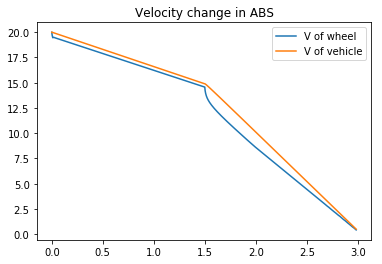

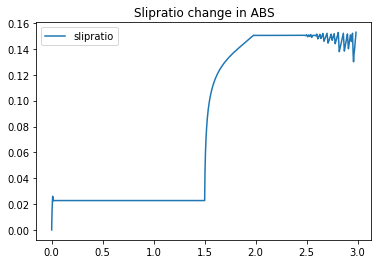

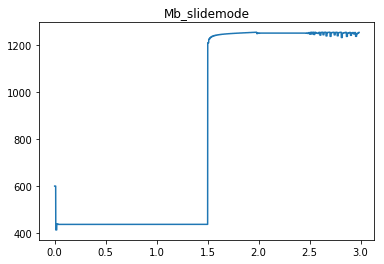

In [4]:
# -*- coding: utf-8 -*-
"""
Created on Wed Jan 16 09:36:59 2019

@author: feiyuxiao
"""

import numpy as np
import math
import matplotlib.pylab as plt

# set parameters
m = 380
g = 9.8
r = 0.325
I = 1.7
v0 = 20
w0 = v0/r

flag = 0
desireSlip = 0.075

slip = 0.075
mu = 1.0


K = 8000 #7700 #8000

# gravity force
FN = m*g

time = 10
# step size
h = 0.0001
size = int(time/h)

v = np.zeros(size)
w = np.zeros(size)
T = np.linspace(0,time,size)
slipratio = np.zeros(size)
slipError = np.zeros(size)
Mb = np.zeros(size)


epsilon = 0.2

v[0] = v0
w[0] = w0


for i in range(size-1):
   
    if i >= 15000:
        flag = 0
        desiredSlip = 0.15
        slip = 0.15
        mu = 0.1
    
    elif i< 15000:
        flag = 1
        desiredSlip = 0.075
        slip = 0.075
        mu = 0.05
  
    slipratio[i] = (v[i]-w[i]*r)/max(v[i],w[i]*r,epsilon) #calculate the slip ratio
    
    
    #print(slipratio[i],i)   
    slipError[i] = slipratio[i] - desiredSlip# e
      
    if flag == 0:
        if slipratio[i] < slip:
            u_lambda = slipratio[i]/slip
        elif slipratio[i] >= slip:
            u_lambda = 1.0 - 0.1*(slipratio[i]-slip)/(1-slip)
    elif flag == 1:
         if slipratio[i] < slip:
            u_lambda = mu*slipratio[i]/slip
         elif slipratio[i] >= slip:
            u_lambda = mu - 0.1*(slipratio[i]-slip)/(1-slip)
            
    
    #u = 1.28*(1-math.exp(-23.99*slipratio[i]) - 0.52*slipratio[i]);        
            
    if i%100 == 0:
        '''
        K = 400
        theta = 0.5
        Mb[i] = I*u_lambda*g*(1-slipratio[i])/r + u_lambda*m*g*r - K*sat(slipError[i],theta)
        '''
        Mb[i] = I*u_lambda*g*(1-slipratio[i])/r + u_lambda*m*g*r - K*slipError[i]
        '''
        if abs(slipError[i]<0.001) :
           print("slip",Mb[i],K*slipError[i])
        if v[i] < 0.5:
            Mb[i] = I*u_lambda*g*(1-slipratio[i])/r + u_lambda*m*g*r
        '''
        #print("u",u_lambda,slipratio[i])
    else:
        Mb[i] = Mb[i-1]
    
    if flag == 0:    
        u = math.sin(1.9*math.atan(10*slipratio[i]-0.97*(10*slipratio[i]-math.atan(10*slipratio[i]))))
       
    else:
        u = 0.5*math.sin(1.9*math.atan(10*2*slipratio[i]-0.97*(10*2*slipratio[i]-math.atan(10*2*slipratio[i]))))
       
    #u = 1.28*(1-math.exp(-23.99*slipratio[i]) - 0.52*slipratio[i]);
    
    dw = (r*u*FN - Mb[i])/I*h
    w[i+1] = w[i]+dw
    
    dv = -u*FN/m*h
    v[i+1] = v[i] + dv
    
    if v[i+1] < 0.5:
        v[i+1] = 0
        t_pos = i+1
        break

v_w = w*r
   
plt.figure()
plt.plot(T[0:t_pos],v_w[0:t_pos],label = "V of wheel")
plt.plot(T[0:t_pos],v[0:t_pos],label = "V of vehicle")
plt.legend(loc = 'best')
plt.title('Velocity change in ABS')
#plt.savefig('velocity_slidemode.png',dpi = 200)

plt.figure()
plt.plot(T[0:t_pos],slipratio[0:t_pos], label = "slipratio")
plt.legend(loc = 'best')
plt.title("Slipratio change in ABS")
#plt.savefig("slipratio_slidemode.png",dpi = 200)

plt.figure()
plt.plot(T[0:t_pos],Mb[0:t_pos], label = "Mb")
plt.title("Mb_slidemode")
#plt.savefig("Mb_slidemode.png",dpi = 200)
